<img src='https://github.com/Ikomia-dev/notebooks/blob/main/examples/img/banner_ikomia.png?raw=true'>




# Easy object detection with MMDetection

**MMDetection** is a comprehensive toolbox that provides a wide array of object detection algorithms. Developed by the Multimedia Laboratory, CUHK, it's part of the OpenMMLab project.

It's designed to facilitate research and development in object detection, instance segmentation, and other related areas.


![MMDetection illustration](https://miro.medium.com/v2/resize:fit:828/format:webp/1*C3o6c7XBOWpaEfxx0juhKg.jpeg)

## Setup

You need to install Ikomia Python API with pip


In [ ]:
!pip install ikomia

## Run MMDetection on your image

---

**-Google Colab ONLY- Restart runtime after the first run of the workflow below** 

Click on the "RESTART RUNTIME" button at the end the previous window.

---

In [ ]:
from ikomia.dataprocess.workflow import Workflow


# Init your workflow
wf = Workflow()

# Add object detection algorithm
detector = wf.add_task(name="infer_mmlab_detection", auto_connect=True)

# Set parameters
detector.set_parameters({
        "model_name": "rtmdet",
        "model_config": "rtmdet_tiny_8xb32-300e_coco",
        "conf_thres": "0.4",
})

# Run the workflow on image
wf.run_on(url="https://github.com/open-mmlab/mmdetection/blob/main/demo/demo.jpg?raw=true")

# Get the results
image_output = detector.get_output(0)
detection_output = detector.get_output(1)

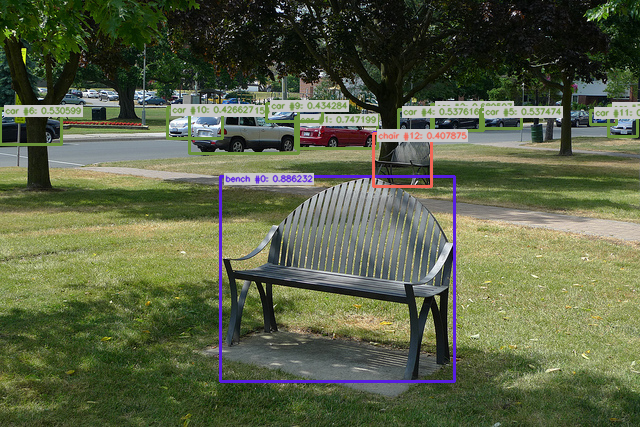

In [5]:
from ikomia.core import IODataType
from ikomia.utils.displayIO import display

from PIL import ImageShow
ImageShow.register(ImageShow.IPythonViewer(), 0)

# Display the results
# MMLab detection framework mixes object detection and instance segmentation algorithms
if detection_output.data_type == IODataType.OBJECT_DETECTION:
    display(image_output.get_image_with_graphics(detection_output), title="MMLAB detection")
elif detection_output.data_type == IODataType.INSTANCE_SEGMENTATION:
    display(image_output.get_image_with_mask_and_graphics(detection_output), title="MMLAB detection")

## List of parameters

- **model_name** (str, default="yolox"): model name.
- **model_config** (str, default="yolox_s_8x8_300e_coco"): name of the model configuration file.
- **conf_thres** (float, default=0.5): object detection confidence.
- **use_custom_model** (bool, default=False): flag to enable the custom train model choice.
- **config_file** (str, default=""): path to model config file (only if use_custom_model=True). The file is generated at the end of a custom training. Use algorithm train_mmlab_detection from Ikomia HUB to train custom model.
- **model_weight_file** (str, default=""): path to model weights file (.pt) (only if use_custom_model=True). The file is generated at the end of a custom training.
- **cuda** (bool, default=True): CUDA acceleration if True, run on CPU otherwise.


MMLab framework for object detection and instance segmentation offers a large range of models. To ease the choice of couple (model_name/model_config), you can call the function get_model_zoo() to get a list of possible values.

In [ ]:
from ikomia.dataprocess.workflow import Workflow

# Init your workflow
wf = Workflow()

# Add object detection algorithm
detector = wf.add_task(name="infer_mmlab_detection", auto_connect=True)

# Get list of possible models (model_name, model_config)
models = detector.get_model_zoo()

for model in models:
    print(model)

### Run MMDetection on Video

*Note: The video stream will work on local only, not on Google Colab.*

In [ ]:
from ikomia.dataprocess.workflow import Workflow
from ikomia.utils.displayIO import display
import cv2

# Use a path to your video
video_input = 'PATH/TO/YOUR/VIDEO.mp4'  # Example video from Pexels: https://www.pexels.com/video/cars-road-people-buildings-4483542/
output_path = 'video_output.mp4'

# Init your workflow
wf = Workflow()

# Add object detection algorithm
detector = wf.add_task(name="infer_mmlab_detection", auto_connect=True)

# Set parameters
detector.set_parameters({
        "model_name": "rtmdet",
        "model_config": "rtmdet_m_8xb32-300e_coco",
        "conf_thres": "0.30",
})

# Open the video file from URL
stream = cv2.VideoCapture(video_input)
if not stream.isOpened():
    print("Error: Could not open video.")
    exit()

# Get video properties for the output
frame_width = int(stream.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(stream.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_rate = stream.get(cv2.CAP_PROP_FPS)

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_path, fourcc, frame_rate, (frame_width, frame_height))

while True:
    # Read image from stream
    ret, frame = stream.read()
    if not ret:
        print("Info: End of video or error.")
        break

    # Run the workflow on current frame
    wf.run_on(array=frame)

    # Get results
    image_out = detector.get_output(0)
    obj_detect_out = detector.get_output(1)

    # Convert the result to BGR color space for displaying
    img_out = image_out.get_image_with_graphics(obj_detect_out)
    img_res = cv2.cvtColor(img_out, cv2.COLOR_RGB2BGR)

    # Save the resulting frame
    out.write(img_out)  # This should be img_res instead of img_out if you intend to save the converted BGR image

    # Display
    display(img_res, title="Object detection", viewer="opencv")

    # Press 'q' to quit the video processing
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release everything after the loop
stream.release()
out.release()
cv2.destroyAllWindows()